У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон»
предлагает обширный набор различных услуг своим абонентам. При этом разным
пользователям интересны разные услуги. Поэтому необходимо построить
алгоритм, который для каждой пары пользователь-услуга определит вероятность
подключения услуги.

### Данные

В качестве исходных данных вам будет доступна информация об отклике
абонентов на предложение подключения одной из услуг. Каждому пользователю
может быть сделано несколько предложений в разное время, каждое из которых он
может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный
анонимизированный набор признаков, характеризующий профиль потребления
абонента. Эти данные привязаны к определенному времени, поскольку профиль
абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test
отложен последующий месяц.

Итого, в качестве входных данных будут представлены:

 - data_train.csv: id, vas_id, buy_time, target
 - features.csv.zip: id, <feature_list>

И тестовый набор:

- data_test.csv: id, vas_id, buy_time
    target - целевая переменная, где 1 означает подключение услуги, 0 - абонент
    не подключил услугу соответственно.
    
    buy_time - время покупки, представлено в формате timestamp, для работы с
    этим столбцом понадобится функция datetime.fromtimestamp из модуля
    datetime.
    
    id - идентификатор абонента
    
    vas_id - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для
работы с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться
библиотекой Dask.

### Метрика

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например
делает функция sklearn.metrics.f1_score(…, average=’macro’)

### Формат представления результата

1. Работающая модель в формате pickle, которая принимает файл data_test.csv
из корневой папки и записывает в эту же папку файл answers_test.csv. В этом
файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно
записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука.
 
3. Презентация в формате .pdf, в которой необходимо отразить:

 - Информация о модели, ее параметрах, особенностях и основных результатах.
 
 - Обоснование выбора модели и ее сравнение с альтернативами.
 
 - Принцип составления индивидуальных предложений для выбранных абонентов.

Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и
резюме необходимо прикрепить ко второму уроку “курсовой проект”

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, classification_report

from sklearn.feature_selection import SelectFromModel, GenericUnivariateSelect, mutual_info_classif

In [33]:
from until import ColumnSelector, undersample_df_by_target, run_grid_search, treshold_search, preprocess_data_train, preprocess_data_test, select_type_cols


In [34]:
TRAIN_DATA = 'data/data_train.csv'
TEST_DATA = 'data/data_train.csv'
FEATURES_DATA = 'data/features.csv'
RANDOM_STATE = 9

In [35]:
train_df = pd.read_csv(TRAIN_DATA)

In [36]:
train_df.head(2)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0


##### Сперва достанем данные из временной метки, и посмотрим распределение целевого признака в разрезе остальных признаков.

In [37]:
train_df = train_df.drop('Unnamed: 0', axis=1)

In [38]:
train_df['buy_time'] = pd.to_datetime(train_df['buy_time'], unit='s') 

In [39]:
train_df['monthday'] = train_df['buy_time'].dt.day
train_df['month'] = train_df['buy_time'].dt.month

- В процессе выяснил, что все звонки были в воскресенье в 21 час. По этому нет смысла добавлять день недели и время звонка. (А жаль, мне кажется было бы полезно)

In [40]:
train_df.head(2)

,id,vas_id,buy_time,target,monthday,month
0,540968,8.0,2018-09-16 21:00:00,0.0,16,9
1,1454121,4.0,2018-07-15 21:00:00,0.0,15,7


In [41]:
train_df = train_df.sort_values('buy_time')

In [42]:
train_df['not_first_offer'] = train_df.duplicated('id').astype(int)

- Выделим пользователей, которым делали предложения больше 1 раза.

##### Целевая переменная

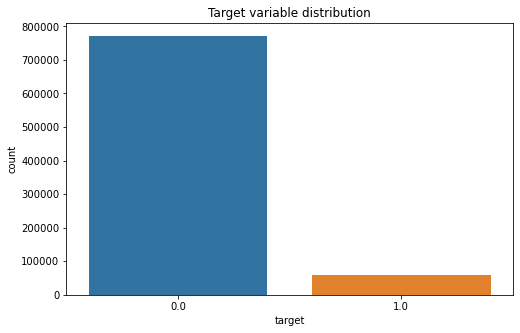

In [43]:
plt.figure(figsize=(8, 5))

sns.countplot(x='target', data=train_df)

plt.title('Target variable distribution')
plt.show()

- Таргет имеет сильный дисбаланс

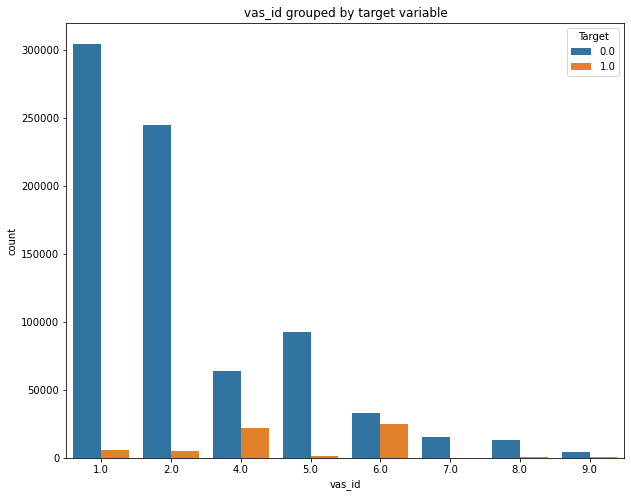

In [44]:
plt.figure(figsize=(10, 8))

sns.countplot(x="vas_id", hue='target', data=train_df)
plt.title('vas_id grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

- Видим, что на услугу "6" положительный отклик, относительно отрицательного, на много выше остальных. Также "4" услуга имеет больший спрос. 

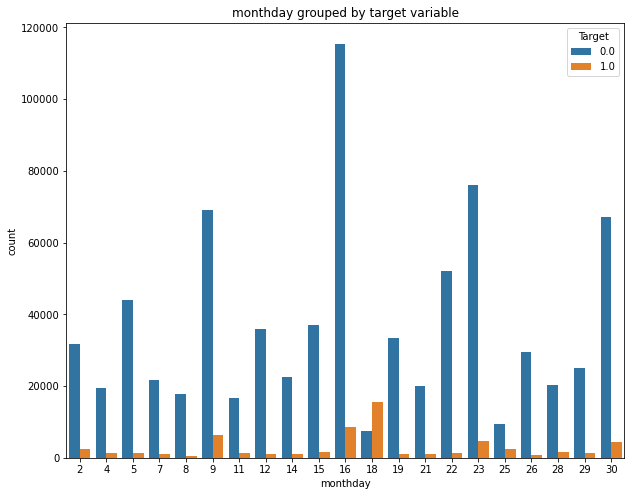

In [45]:
plt.figure(figsize=(10, 8))

sns.countplot(x="monthday", hue='target', data=train_df)
plt.title('monthday grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

- Наблюдается сильный прекос отклика в положительную сторону в середине месяца, может это период зарплаты, когда люди более лояльны к новым покупкам. Ну и в целом видно, что в это время пик предложений, видимо маркетинг тоже пришел к выводу, что лучше звонить в эти дни. 

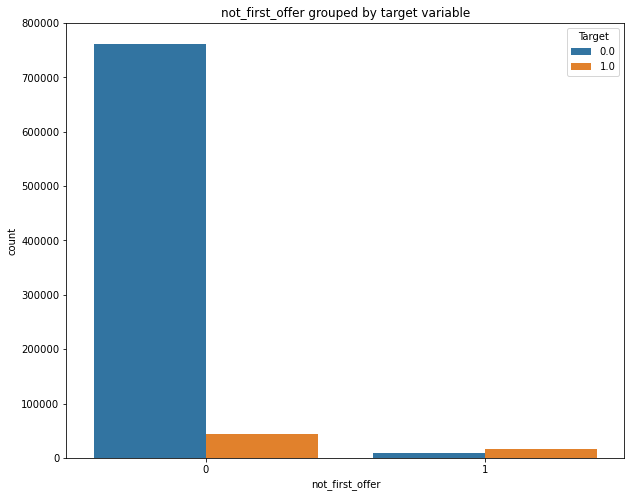

In [46]:
plt.figure(figsize=(10, 8))

sns.countplot(x="not_first_offer", hue='target', data=train_df)
plt.title('not_first_offer grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

- Интересно, что те, кому звонили не в первый раз, имеют явный перекос в сторону положительного отклика. 

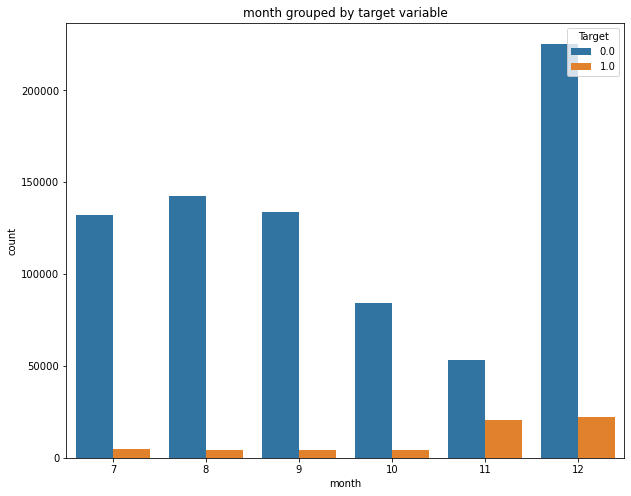

In [47]:
plt.figure(figsize=(10, 8))

sns.countplot(x="month", hue='target', data=train_df)
plt.title('month grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

- Видно, что в Ноябре \ Декабре имеется явное увеличение положительных откликов. В декабре большое количество предложений, возможно предлагали новогоднюю акцию или старались закрыть план за год.

In [48]:
sample = train_df.loc[(train_df['not_first_offer'] == 1) & (train_df['monthday'].isin([16, 17, 18, 19, 20]))]

In [49]:
sample['target'].value_counts(normalize=True)

1.0    0.830852
0.0    0.169148
Name: target, dtype: float64

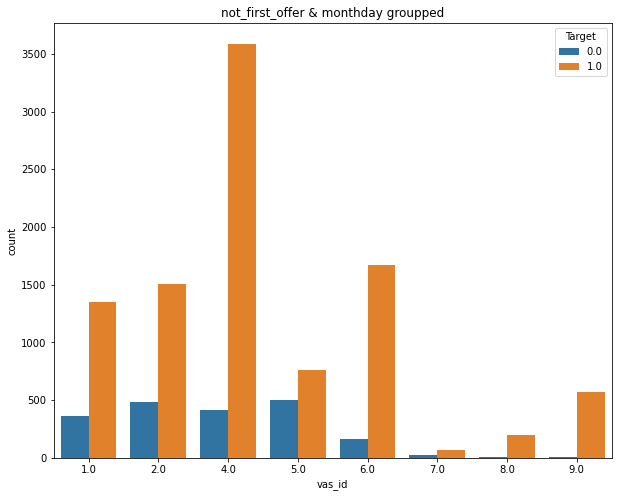

In [50]:
plt.figure(figsize=(10, 8))

sns.countplot(x="vas_id", hue='target', data=sample)
plt.title('not_first_offer & monthday groupped')
plt.legend(title='Target', loc='upper right')

plt.show()

##### Из приведенных выше данных, можно сделать предположение: "Всегда нужно звонить повторно, звонить стоит в середине месяца". При этом не чаще раза в месяц, и предлагать разные услуги. Даже без дополнительных описательных характеристик пользователя, мы видим, что вероятность положительного отклика на любую услугу в этих рамках много выше. 

#### Посмотрим описательные характеристики

In [51]:
features_df = dd.read_csv(FEATURES_DATA, sep='\t')

In [52]:
features_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [53]:
features_df = features_df.drop('Unnamed: 0', axis=1)

- Чтобы смерджить описательные фичи, возьмем из них только те id, которые есть в трейн датасете.

In [54]:
train_list_index = list(train_df['id'].unique())

In [55]:
features_df = features_df.loc[features_df['id'].isin(train_list_index)].compute()

- Т.к. имеются дубликаты ИД в описательном датасете, подразумевается, что со временем предпочтения менялись берем ближайшую по времени информацию. Если данных не будет, будет nan который мы обработаем в пайплайне заполнив на какую-нибудь статистику.

In [56]:
features_df['buy_time'] = pd.to_datetime(features_df['buy_time'], unit='s')

In [57]:
features_df = features_df.sort_values(by="buy_time")

In [58]:
train_data = pd.merge_asof(train_df, features_df, on='buy_time', by='id', direction='nearest')

- Проверим, совпадают ли значения

In [59]:
import random

rid = random.choice(train_list_index)
print(rid)
features_df.loc[features_df['id'] == rid]


3325812


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
10197,3325812,2018-12-09 21:00:00,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,...,-132.373846,-604.770792,-25.996269,-37.630448,-290.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [60]:
train_data.loc[train_data['id'] == rid]

,id,vas_id,buy_time,target,monthday,month,not_first_offer,0,1,2,...,243,244,245,246,247,248,249,250,251,252
460224,3325812,4.0,2018-10-14 21:00:00,0.0,14,10,0,-96.799971,-408.179112,-110.740786,...,-132.373846,-604.770792,-25.996269,-37.630448,-290.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [61]:
train_data.drop(['id', 'buy_time', 'month'], axis=1, inplace=True)

In [62]:
print("ID уникален? ", train_data.index.is_unique)
print("Есть ли дубли в строках?", train_data.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((train_data.isnull().sum() > 0).sum()/train_data.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 732
Сколько процент признаков могут принимать null-значениями? 0%


In [63]:
train_data.drop_duplicates(inplace=True)

In [64]:
train_data['target'].value_counts(normalize=True)

0.0    0.927582
1.0    0.072418
Name: target, dtype: float64

- Посмотрим на корреляцию между целевой и остальными признаками. 

In [65]:
corr_matrix = train_data.corr()[['target']]

In [66]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.3].shape[0] - 1

1

In [67]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.2].shape[0] - 1

2

In [68]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.1].shape[0] - 1

2

In [69]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.05].shape[0] - 1

2

In [70]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.01].shape[0] - 1

2

In [71]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.001]

,target
vas_id,0.262972
target,1.000000
monthday,0.007250
not_first_offer,0.372296
0,0.001181
...,...
241,-0.004290
243,-0.001036
245,0.003425
247,-0.001163


 - Очень слабая корреляция. Либо связь не линейная т.к. имеются по сути категориальные признаки, либо просто признаки бесполезные. 

### Подготовим данные, разобьем на трейн\тест по времени.

In [72]:
train_df = pd.read_csv(TRAIN_DATA)

- Разделим на трейн\тест. Берем половину последнего месяца.

In [73]:
train_df['buy_time'] = pd.to_datetime(train_df['buy_time'], unit='s')

In [74]:
new_train_df = train_df.loc[~((train_df['buy_time'].dt.month == 12) & (train_df['buy_time'].dt.day > 10))]

In [75]:
valid_df = train_df.loc[((train_df['buy_time'].dt.month == 12) & (train_df['buy_time'].dt.day > 10))]

- Сделаем балансировку андерсемплингом так как данных много

In [76]:
X_train = undersample_df_by_target(new_train_df, 'target')

In [77]:
X_train, true_offers_ids = preprocess_data_train(X_train, FEATURES_DATA)

In [78]:
y_train = X_train['target']

In [79]:
X_train = X_train.drop('target', axis = 1)

In [80]:
y_train.value_counts()

0.0    45103
1.0    45103
Name: target, dtype: int64

In [81]:
valid_df = preprocess_data_test(valid_df, FEATURES_DATA, true_offers_ids)

C:\Users\user\Git\megafon\project\until.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_data_df['buy_time'] = pd.to_datetime(prep_data_df['buy_time'], unit='s')
C:\Users\user\Git\megafon\project\until.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_data_df['monthday'] = prep_data_df['buy_time'].dt.day


In [82]:
y_test = valid_df['target']

In [83]:
X_test = valid_df.drop('target', axis = 1)

In [84]:
y_test.value_counts()

0.0    178557
1.0     15083
Name: target, dtype: int64

- И так, для начала сделаем Бейзлайн, оценив, что мы можем получить.

In [85]:
rf = RandomForestClassifier()

In [86]:
step_imputer = SimpleImputer(strategy="mean")

In [87]:
baseline = Pipeline([
    ('imuter', step_imputer),
    ('model', rf)
])

In [88]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('imuter', SimpleImputer()),
                ('model', RandomForestClassifier())])

In [89]:
preds = baseline.predict(X_test)

In [90]:
f1_score(y_test, preds, average='macro')

0.5588602286175735

In [91]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.66      0.79    178557
         1.0       0.20      0.99      0.33     15083

    accuracy                           0.68    193640
   macro avg       0.60      0.82      0.56    193640
weighted avg       0.94      0.68      0.76    193640



- Начальный результат для использования данных "как есть", F-Score=0.76, F1-macro 0.56

===========================================================================================================

#### Попробуем глянуть, что за фичи мы имеем.

- И так, соберем списки признаков

In [92]:
f_all, f_binary, f_categorical, f_numeric = select_type_cols(X_train)

- Создадим пайплайн для препроцессинга. В нем мы стандартизируем вещественные признаки, что бы попробовать использовать линейную модель, и и сделаем OHE категориальных признаков. Также добавим шаги по автозаполнению пропусков.  

In [93]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_all),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

- Попробуем наш бейзлайн на новых фичах. По сути для Леса изменилось только кодирование кат.фич.

In [65]:
rf_pipe = make_pipeline(
    f_prep_pipeline,
    RandomForestClassifier(random_state=RANDOM_STATE)
)

In [66]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                                                                                                           '201',
                                                                                                           '32',
                                                                                                           '28',
                                                                                                           '133',
                                                                                                           'vas_id',
                                                                                                           '30',
                                                                                                           '177',
                                                                                                           '155',
                                                                                                           '202', ...])),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['not_first_offer']))]))]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=9))])

In [67]:
preds = rf_pipe.predict(X_test)

In [68]:
f1_score(y_test, preds, average='macro')

0.7480097451667269

In [69]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.39      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



- Не плохой прирост, +4% точности F1-macro, это хороший результат.

========================================================================================================================

- Теперь попробуем линейный алгоритм.

In [70]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [71]:
lg_pipe.fit(X_train, y_train)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                                                                                                           '80',
                                                                                                           '201',
                                                                                                           '32',
                                                                                                           '28',
                                                                                                           '133',
                                                                                                           'vas_id',
                                                                                                           '30',
                                                                                                           '177',
                                                                                                           '155',
                                                                                                           '202', ...])),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['not_first_offer']))]))]))])),
                ('logisticregression', LogisticRegression(random_state=9))])

In [72]:
preds = lg_pipe.predict(X_test)

In [73]:
f1_score(y_test, preds, average='macro')

0.7485477602341992

In [74]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



- Результат очень близкий, при этом скорость на много выше.

========================================================================================================================

- Произведем отбор фичей. Попробуем использовать метод с Лассо регрессией и Взаимной информации. В качестве контрольной модели будем использовать Лог рег, т.к. она хорошо себя показала, и работает довольно быстро.

In [75]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='liblinear'), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [76]:
params = [
    {"selectfrommodel__max_features": [None,15, 30,80,120,200,250],
     "selectfrommodel__threshold": [-np.inf],
     "selectfrommodel__estimator__C" : [1, 0.5, 0.01, 0.1]
    }
    
]

run_grid_search(lg_fs_pipe, X_train, y_train, params, scoring='f1')

Best f1 score: 0.90

Best parameters set found on development set:

{'selectfrommodel__estimator__C': 1, 'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}


- Удивительно, но даже при 5 фичах качество практически такое же, как и при полном наборе.

========================================================================================================================

In [94]:
lg_fs_pipe_kbest_selector = make_pipeline(
    f_prep_pipeline,
    GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=100),
    RandomForestClassifier(random_state=RANDOM_STATE)
)


In [95]:
params = [
    {'genericunivariateselect__param' : [15, 30,50,70,80,100,120,150,200,250]},
    
]


Best f1 score: 0.90

Best parameters set found on development set:

{'genericunivariateselect__param': 70}


- Будем использовать: SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), threshold=1e-5). Т.к. 


==================================================================================================

In [79]:
rf_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), max_features = 29, threshold = -np.inf),
    RandomForestClassifier(random_state=RANDOM_STATE, )
)

In [80]:
params = [
    {'randomforestclassifier__max_features': ['sqrt', 'log2', 2, 5, 8, 10],
     'randomforestclassifier__n_estimators' : [50, 100, 200, 300],    
    }   
]

Best f1 score: 0.90

Best parameters set found on development set:

{'randomforestclassifier__max_features': 8, 'randomforestclassifier__n_estimators': 300}

In [81]:
rf_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), max_features = 29, threshold = -np.inf),
    RandomForestClassifier(random_state=RANDOM_STATE, max_features = 8, n_estimators = 300)
)

In [82]:
rf_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['not_first_offer']))]))]))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=9,
                                                              solver='liblinear'),
                                 max_features=29, threshold=-inf)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=8, n_estimators=300,
                                        random_state=9))])

In [83]:
preds_train = rf_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.8733716415934062

In [84]:
preds_test = rf_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7462195008902737

In [85]:
preds_proba_train = rf_fs_pipe.predict_proba(X_train)

In [86]:
preds_proba_test = rf_fs_pipe.predict_proba(X_test)

In [87]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5789473684210527, Метрика F1_macro: 0.8733718084251102
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [88]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7487542786325825
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



=======================================================================================================

In [89]:
rf_gu_pipe = make_pipeline(
    f_prep_pipeline,
    GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=50),
    RandomForestClassifier(random_state=RANDOM_STATE, n_estimators = 300)
)

In [90]:
rf_gu_pipe.fit(X_train, y_train)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['not_first_offer']))]))]))])),
                ('genericunivariateselect',
                 GenericUnivariateSelect(mode='k_best', param=50,
                                         score_func=<function mutual_info_classif at 0x0000021F2D0704C0>)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=300, random_state=9))])

In [91]:
preds_train = rf_gu_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.9966631911833572

In [92]:
preds_test = rf_gu_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7466320212976887

In [93]:
preds_proba_train = rf_gu_pipe.predict_proba(X_train)

In [94]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5263157894736842, Метрика F1_macro: 0.996663192689143
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45103
         1.0       1.00      1.00      1.00     45103

    accuracy                           1.00     90206
   macro avg       1.00      1.00      1.00     90206
weighted avg       1.00      1.00      1.00     90206



In [95]:
preds_proba_test = rf_gu_pipe.predict_proba(X_test)

In [96]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7476131150558742
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93    178557
         1.0       0.40      0.97      0.56     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.92      0.75    193640
weighted avg       0.95      0.88      0.90    193640



================================================================================================================

In [97]:
xgb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), max_features = 29, threshold = -np.inf),
    XGBClassifier(random_state=RANDOM_STATE)
)

In [98]:
params = [
    {'xgbclassifier__max_depth': [1,2,3,4,5],
     'xgbclassifier__n_estimators' : [200, 300, 400],     
    }    
]

Best parameters set found on development set:

{'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 200}

In [99]:
xgb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), max_features = 29, threshold = -np.inf),
    XGBClassifier(random_state=RANDOM_STATE, max_depth = 2, n_estimators = 200)
)

In [100]:
xgb_fs_pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:06:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=9, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [101]:
preds_train = xgb_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.8731165499114395

In [102]:
preds_test = xgb_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7464206336333941

In [103]:
preds_proba_train = xgb_fs_pipe.predict_proba(X_train)

In [104]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5263157894736842, Метрика F1_macro: 0.8731276996608879
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [105]:
preds_proba_test = xgb_fs_pipe.predict_proba(X_test)

In [106]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7488700854737571
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



=================================================================================

In [107]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), max_features = 29),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [108]:
lg_fs_pipe.fit(X_train, y_train)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['not_first_offer']))]))]))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=9,
                                                              solver='liblinear'),
                                 max_features=29)),
                ('logisticregression', LogisticRegression(random_state=9))])

In [109]:
preds_train = lg_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.8730061039189476

In [110]:
preds_test = lg_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7488437802436829

In [111]:
preds_proba_train = lg_fs_pipe.predict_proba(X_train)

In [112]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5789473684210527, Метрика F1_macro: 0.8730283994176793
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [113]:
preds_proba_test = lg_fs_pipe.predict_proba(X_test)

In [114]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.5, Метрика F1_macro: 0.7488437802436829
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



In [115]:
lgbm_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'),max_features = 29, threshold=1e-5),
    LGBMClassifier(random_state=RANDOM_STATE)
)

In [116]:
params = [
    {
     'lgbmclassifier__n_estimators' : [100, 200, 300]     
    } 
]

In [117]:
lgbm_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'),max_features = 29, threshold=1e-5),
    LGBMClassifier(random_state=RANDOM_STATE, n_estimators = 200)
)

In [118]:
lgbm_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['not_first_offer']))]))]))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=9,
                                                              solver='liblinear'),
                                 max_features=29, threshold=1e-05)),
                ('lgbmclassifier',
                 LGBMClassifier(n_estimators=200, random_state=9))])

In [119]:
preds_train = lgbm_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.873160979800135

In [120]:
preds_test = lgbm_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7464217281700052

In [121]:
preds_proba_train = lgbm_fs_pipe.predict_proba(X_train)

In [122]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5789473684210527, Метрика F1_macro: 0.8731831945352724
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [123]:
preds_proba_test = lgbm_fs_pipe.predict_proba(X_test)

In [124]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7488702918468509
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



=================================================================================================

In [125]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='liblinear', C = 0.1), max_features = 15),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [126]:
lg_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['49', '65', '233',
                                                          '227', '92', '77',
                                                          '13', '8', '163',
                                                          '39', '55', '53',
                                                          '197', '110', '140',
                                                          '251', '153', '188',
                                                          '176', '204', '58',
                                                          'monthday', '111',
                                                          '211', '125', '187',
                                                          '30', '222', '36',
                                                          '181', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_features',
                                                                  Pipeline(steps=[('...
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore'))])),
                                                                 ('boolean_features',
                                                                  Pipeline(steps=[('columnselector',
                                                                                   ColumnSelector(columns=['not_first_offer']))]))]))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                              random_state=9,
                                                              solver='liblinear'),
                                 max_features=15)),
                ('logisticregression', LogisticRegression(random_state=9))])

In [127]:
preds_train = lg_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.8730283585954814

In [128]:
preds_test = lg_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7488437802436829

In [129]:
preds_proba_train = lg_fs_pipe.predict_proba(X_train)

In [130]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5, Метрика F1_macro: 0.8730283585954814
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [131]:
preds_proba_test = lg_fs_pipe.predict_proba(X_test)

In [132]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.5, Метрика F1_macro: 0.7488437802436829
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



### Итог

Принял решение взять простую линейную модель, с отбором признаков методом l1 регуляризации.


Если сравнивать по weighted avg метрике (т.к. на тесте мы на трейне делали балансировку, а на тесте нет), то модель не склонна переобучиваться. При этом качество более сложных модели практически одинаково, а иногда и немного хуже, в то время, как ЛогРег работает быстрее прочих.

Лучшая отсечка по вероятности : 0.5, Метрика F1_macro: 0.749 на тестовой выборке.